In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
v_idx = 0
u_idx = 1

In [3]:
def backward_euler(func, dfunc, past_states, constants, error_min = 1e-9, clip_lim = 20):
    temp_states = past_states.copy()
    error = np.ones_like(temp_states)
    max_error = 1
    while  max_error > error_min:
         
        f = func(temp_states, past_states, constants)
        df = dfunc(temp_states, past_states, constants)

        error = np.dot(np.linalg.inv(df), f)
        error = np.clip(error, -clip_lim, clip_lim)

        temp_states = np.subtract(temp_states, error)
    
        max_error = np.amax(np.absolute(error))
    return temp_states

In [4]:
def izhi_f(states, past_states, constants):
    F = np.zeros((2,1))
    
    F[0] = past_states[v_idx] -states[v_idx] + constants['del_t']*(0.04 * states[v_idx]**2 + 5*states[v_idx] + 140 - states[u_idx] + constants['i'])
    F[1] = past_states[u_idx] - states[u_idx] + constants['del_t']*constants['a']*(constants['b'] * states[v_idx] - states[u_idx])
    
    return F


In [5]:
def izhi_df(states, past_states, constants):
    
    j_f = np.zeros((2,2))
    
    j_f[0][0] = - 1 + constants['del_t']*(0.08*states[v_idx] + 5)
    j_f[0][1] = -constants['del_t']                                                           
    
    j_f[1][0] = constants['del_t']*constants['a']*constants['b']
    j_f[1][1] = - 1 - constants['del_t']*constants['a']
    
    return j_f

In [6]:
def compute_samples(input_i, init_states, constants):
    ret_val = []
    past_states = init_states.copy()
    for i in range(input_i.shape[0]):
        constants['i'] = input_i[i]
        past_states = backward_euler(izhi_f, izhi_df, past_states, constants)
        if past_states[v_idx] >= 30:
            past_states[v_idx] = constants['c']
            past_states[u_idx] += constants['d']
        ret_val.append(past_states)
    return np.array(ret_val).reshape(-1, past_states.shape[0])  

In [7]:
def compute_firing_rate(series, t, thr=-40):
    #temp = np.clip(series, a_max=thr)
    idx_thr = series > thr
    num_spikes = 0
    spike_idx = []
    for i in range(1, series.shape[0]-1):
        if idx_thr[i-1] ==False and idx_thr[i]==True:
            num_spikes+=1
            spike_idx.append(t[i])
    spike_idx = np.array(spike_idx) *1e-3 # to second
    
    if num_spikes <= 2: 
        return 0
    else:
        isi = np.mean(np.diff(spike_idx[1:]))
        return 1./isi

In [8]:
def compute_windowed_isi(series, t, window_size=128):
    num_data = t.shape[0]-window_size
    ret = np.zeros_like(t)
    for i in range(num_data):
        w_series = series[i:i+window_size]
        w_t = t[i:i+window_size]
        ret[i+window_size] = compute_firing_rate(w_series, w_t) 
    return ret

In [9]:
def compute_steadystate_amp(series):
    upper = np.max(series)
    lower = np.min(series)
    return 0.5*(upper - lower)

In [10]:
def find_thr_current(lower_bound, upper_bound, tolerance = 1e-3, max_iter = 1000):
    n_iter = 0
    converge = False
    while not converge:
        n_iter+=1
        mid_point = 0.5*(upper_bound + lower_bound)

        input_i = np.full(t.shape[0], mid_point)
        result = compute_samples(input_i, init_states, constants)
        firing_rate = compute_firing_rate(result[:,v_idx],t)
        print('firing rate at {:.4f} mA is {:.2f}'.format(mid_point, firing_rate))

        if ((firing_rate > 0) and (0.5*(upper_bound - lower_bound) < tolerance)) or (n_iter >=max_iter):
            converge = True
        else:
            if firing_rate > 0:
                upper_bound = mid_point
            else:
                lower_bound = mid_point
    return mid_point

# 1

In [11]:
constants = {}
constants['a'] = 0.1
constants['b'] = 0.05
constants['c'] = -50
constants['d'] = 8

sample_rate = 16
max_t = 500
constants['del_t'] = 1/sample_rate

init_states = np.array([-80, 0]).reshape((-1,1))

t = np.arange(0, max_t, step = constants['del_t'])

lower_bound = 0
upper_bound = 15

i_thr = find_thr_current(lower_bound, upper_bound)

print('Neuron starts firing at {:.4f} mA'.format(i_thr))

firing rate at 7.5000 mA is 0.00
firing rate at 11.2500 mA is 0.00
firing rate at 13.1250 mA is 0.00
firing rate at 14.0625 mA is 26.98
firing rate at 13.5938 mA is 21.14
firing rate at 13.3594 mA is 16.97
firing rate at 13.2422 mA is 13.77
firing rate at 13.1836 mA is 11.07
firing rate at 13.1543 mA is 8.37
firing rate at 13.1396 mA is 0.00
firing rate at 13.1470 mA is 6.91
firing rate at 13.1433 mA is 0.00
firing rate at 13.1451 mA is 6.33
firing rate at 13.1442 mA is 5.97
Neuron starts firing at 13.1442 mA


In [40]:
i_s = np.linspace(i_thr*0.95, i_thr+1.5,40).tolist()

firing_rates = []

for i in i_s:
    input_i = np.full(t.shape[0], i)
    result = compute_samples(input_i, init_states, constants)
    firing_rates.append(compute_firing_rate(result[:,v_idx],t))


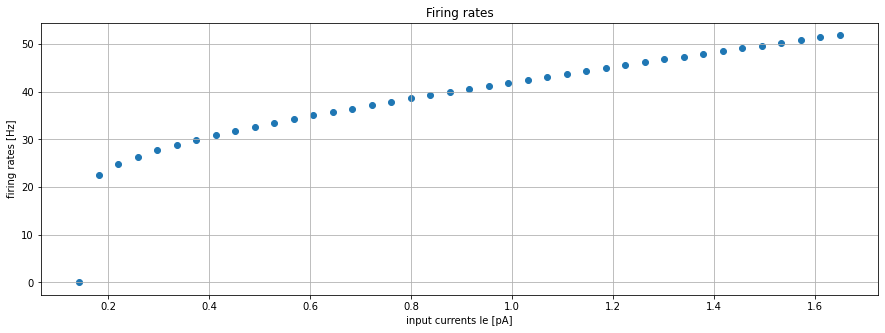

In [41]:
plt.figure(figsize=(15,5))

plt.scatter(i_s, firing_rates)
plt.title('Firing rates')
plt.xlabel('input currents Ie [pA]')
plt.ylabel('firing rates [Hz]')
plt.grid()
plt.show()

In [30]:
ws = np.linspace(0,1,20)
results = []
transfer_function = []
for w in ws:
    input_i = i_thr - 0.05 + 0.04*np.cos(w*t)
    result = compute_samples(input_i, init_states, constants)
    output = result[:,v_idx]
    results.append(output)
    transfer_function.append(compute_steadystate_amp(output[-int(t.shape[0] *0.25):]))

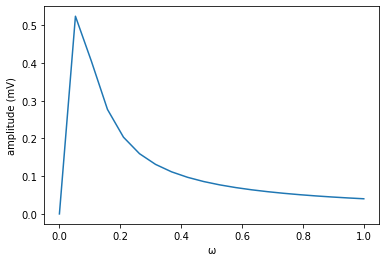

In [31]:
plt.plot(ws, transfer_function)
plt.ylabel('amplitude (mV)')
plt.xlabel('ω')
plt.show()

# 2

In [32]:
constants = {}
constants['a'] = 0.1
constants['b'] = 0.26
constants['c'] = -65
constants['d'] = 2
constants['del_t'] = 1/sample_rate

init_states = np.array([-80, 0]).reshape((-1,1))

lower_bound = 0
upper_bound = 15

i_thr = find_thr_current(lower_bound, upper_bound)

print('Neuron starts firing at {:.4f} pA'.format(i_thr))

firing rate at 7.5000 mA is 150.20
firing rate at 3.7500 mA is 84.39
firing rate at 1.8750 mA is 55.30
firing rate at 0.9375 mA is 41.00
firing rate at 0.4688 mA is 32.08
firing rate at 0.2344 mA is 25.37
firing rate at 0.1172 mA is 0.00
firing rate at 0.1758 mA is 22.02
firing rate at 0.1465 mA is 0.00
firing rate at 0.1611 mA is 20.40
firing rate at 0.1538 mA is 18.98
firing rate at 0.1501 mA is 17.08
firing rate at 0.1483 mA is 0.00
firing rate at 0.1492 mA is 0.00
firing rate at 0.1497 mA is 16.40
Neuron starts firing at 0.1497 pA


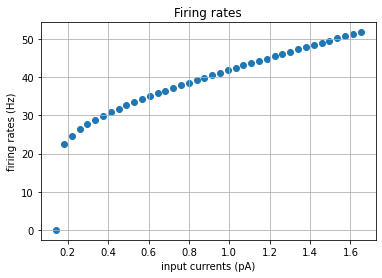

In [36]:
i_s = np.linspace(i_thr*0.95, i_thr+1.5,40).tolist()

firing_rates = []

for i in i_s:
    input_i = np.full(t.shape[0], i)
    result = compute_samples(input_i, init_states, constants)
    firing_rates.append(compute_firing_rate(result[:,v_idx],t))


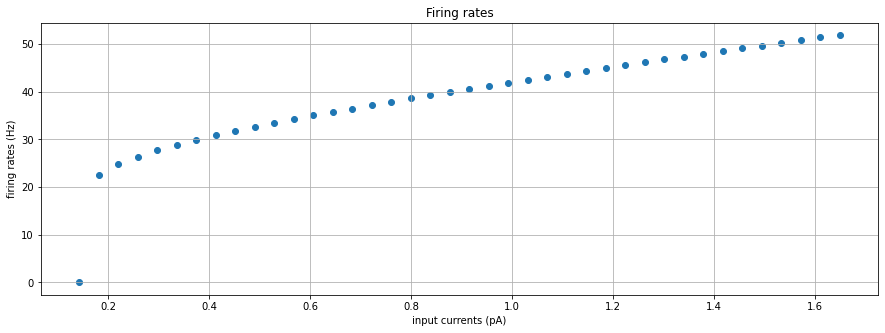

In [37]:
plt.figure(figsize=(15,5))
plt.scatter(i_s, firing_rates)
plt.title('Firing rates')
plt.xlabel('input currents (pA)')
plt.ylabel('firing rates (Hz)')
plt.grid()
plt.show()

In [38]:
results = []
transfer_function = []
for w in ws:
    input_i = i_thr - 0.05 + 0.04*np.cos(w*t)
    result = compute_samples(input_i, init_states, constants)
    output = result[:,v_idx]
    results.append(output)
    transfer_function.append(compute_steadystate_amp(output[-int(t.shape[0] *0.25):]))

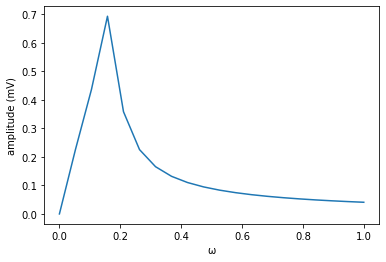

In [39]:
plt.plot(ws, transfer_function)
plt.ylabel('amplitude (mV)')
plt.xlabel('ω')
plt.show()

# 3

Please plot phase plot, check what parameter D does, also plot nullcline v, nullcline u.

backward euler, show particular plot. explain dynamics in phase portrait. take place between reset and rest. how increase in current affect the nullcline. 

In [25]:
constants = {}
constants['a'] = 0.003
constants['b'] = 0
constants['c'] = -65
constants['d'] = 0.2
constants['del_t'] = 1/sample_rate

input_i = np.full(t.shape, 18)
input_i[np.where(t<100)] = 16

result = compute_samples(input_i, init_states, constants)
output = result[:,v_idx]

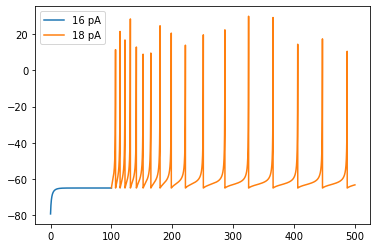

In [26]:
idx_1 = np.where(t<100)
idx_2 = np.where(t>=100)

plt.plot(t[idx_1],output[idx_1], label = '16 pA')
plt.plot(t[idx_2],output[idx_2], label = '18 pA')
plt.legend()

plt.show()

In [29]:
firing_rates = compute_windowed_isi(output, t, window_size = 2048)

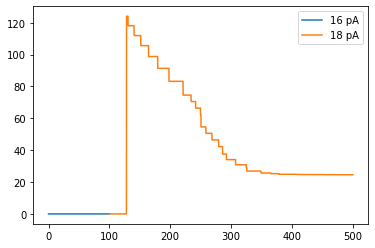

In [30]:
plt.plot(t[idx_1], firing_rates[idx_1], label='16 pA')
plt.plot(t[idx_2], firing_rates[idx_2], label='18 pA')
plt.legend()
plt.show()

# 4

In [24]:
def compute_samples_d(input_i, init_states, constants):
    ret_val = []
    past_states = init_states.copy()
    for i in range(input_i.shape[0]):
        constants['i'] = input_i[i]
        past_states = backward_euler(izhi_f, izhi_df, past_states, constants)
        if past_states[v_idx] > 30:
            past_states[v_idx] = constants['c']
            past_states[u_idx] += constants['d']
        ret_val.append(past_states)
    return np.array(ret_val).reshape(-1, past_states.shape[0])  